## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net, NaimishNet

# net = NaimishNet()
# net = Net()
# net = nn.DataParallel(net, device_ids=[0])

# cudnn.benchmark = True
# net.cuda()

# print(net)

In [3]:
#initialize naimishNet
net = NaimishNet()

net.cuda()

print(net)

NaimishNet(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c1_drop): Dropout(p=0.1)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2_drop): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3_drop): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4_drop): Dropout(p=0.4)
  (fc_1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 20

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=8)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=8)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output(cuda=False):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        if cuda:
            images = images.cuda(async=True)
            key_pts = key_pts.cuda(async=True)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output(cuda=True)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

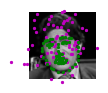

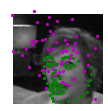

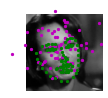

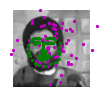

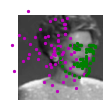

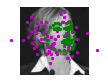

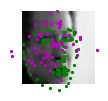

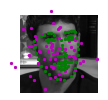

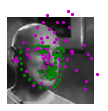

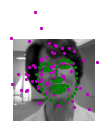

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10, cuda=False):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        if cuda:
            
            image = image.cpu().numpy()   # convert to numpy array from a Tensor
            
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        
        if cuda:
            
            predicted_key_pts = predicted_key_pts.cpu().numpy()
            gt_pts = gt_pts.cpu()
            
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, cuda=True)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

# VGG16 Pre-trained model for training 

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
from tqdm import tqdm, tqdm_notebook

def train_net(n_epochs, cuda=False):
    
    #initialize liveloss
#     liveloss= PlotLosses()

    # prepare the net for training
    net.train()
    
#     total_loss = []

    for epoch in tqdm_notebook(range(n_epochs), desc="training"):  # loop over the dataset multiple times
        
        #logging
#         logs = {}
        
        running_loss = 0.0
#         batch_running_loss = 0.0
        
        batch_i = 0

        # train on batches of data, assumes you already have train_loader
        for data in tqdm_notebook(train_loader, desc="epoch {}".format(epoch)):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            #convert to cuda
            if cuda:
                key_pts = key_pts.cuda(async=True)
                images = images.cuda(async=True)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

#             print loss statistics
#             to convert loss into a scalar and add it to the running_loss, use .item()

            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                tqdm.write('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(
                    epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
            
            
            batch_i+=1

#             running_loss += loss.detach() * images.size(0)
    
#         epoch_loss = running_loss/len(train_loader.dataset)
#             print(len(train_loader.dataset))
        
    #         live loss code
#         logs['log loss'] = epoch_loss.item()
#         
#         liveloss.update(logs)
#         liveloss.send()

    print('Finished Training')


# Training on custom model

In [16]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs, cuda=True)

C:\Users\Aliab\Anaconda3\envs\cvnd\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\Users\Aliab\Anaconda3\envs\cvnd\lib\site-packages\ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch: 1, Batch: 10, Avg. Loss: 5.5114088475704195
Epoch: 1, Batch: 20, Avg. Loss: 0.32532341182231905
Epoch: 1, Batch: 30, Avg. Loss: 0.2688292220234871
Epoch: 1, Batch: 40, Avg. Loss: 0.25994373857975006
Epoch: 1, Batch: 50, Avg. Loss: 0.24334236085414887
Epoch: 1, Batch: 60, Avg. Loss: 0.25371034890413285
Epoch: 1, Batch: 70, Avg. Loss: 0.24510992169380189
Epoch: 1, Batch: 80, Avg. Loss: 0.21867172569036483
Epoch: 1, Batch: 90, Avg. Loss: 0.21119771003723145
Epoch: 1, Batch: 100, Avg. Loss: 0.1868223264813423
Epoch: 1, Batch: 110, Avg. Loss: 0.16381873339414596
Epoch: 1, Batch: 120, Avg. Loss: 0.15108231008052825
Epoch: 1, Batch: 130, Avg. Loss: 0.13411857634782792
Epoch: 1, Batch: 140, Avg. Loss: 0.13065094426274299
Epoch: 1, Batch: 150, Avg. Loss: 0.11499690189957619
Epoch: 1, Batch: 160, Avg. Loss: 0.11012026891112328
Epoch: 1, Batch: 170, Avg. Loss: 0.09320393539965152



Epoch: 2, Batch: 10, Avg. Loss: 0.08966717571020126
Epoch: 2, Batch: 20, Avg. Loss: 0.10489780008792877
Epoch: 2, Batch: 30, Avg. Loss: 0.10361737832427025
Epoch: 2, Batch: 40, Avg. Loss: 0.08990243971347808
Epoch: 2, Batch: 50, Avg. Loss: 0.10427067577838897
Epoch: 2, Batch: 60, Avg. Loss: 0.09838585108518601
Epoch: 2, Batch: 70, Avg. Loss: 0.10589113011956215
Epoch: 2, Batch: 80, Avg. Loss: 0.08603505119681358
Epoch: 2, Batch: 90, Avg. Loss: 0.09720666445791722
Epoch: 2, Batch: 100, Avg. Loss: 0.0884142905473709
Epoch: 2, Batch: 110, Avg. Loss: 0.10240796580910683
Epoch: 2, Batch: 120, Avg. Loss: 0.11157712191343308
Epoch: 2, Batch: 130, Avg. Loss: 0.1071148119866848
Epoch: 2, Batch: 140, Avg. Loss: 0.07828608602285385
Epoch: 2, Batch: 150, Avg. Loss: 0.09982516691088676
Epoch: 2, Batch: 160, Avg. Loss: 0.08616615682840348
Epoch: 2, Batch: 170, Avg. Loss: 0.09120548851788043



Epoch: 3, Batch: 10, Avg. Loss: 0.09325108863413334
Epoch: 3, Batch: 20, Avg. Loss: 0.08953381180763245
Epoch: 3, Batch: 30, Avg. Loss: 0.09155623875558376
Epoch: 3, Batch: 40, Avg. Loss: 0.08003882579505443
Epoch: 3, Batch: 50, Avg. Loss: 0.08778582066297531
Epoch: 3, Batch: 60, Avg. Loss: 0.1014994204044342
Epoch: 3, Batch: 70, Avg. Loss: 0.08685537800192833
Epoch: 3, Batch: 80, Avg. Loss: 0.08504609540104865
Epoch: 3, Batch: 90, Avg. Loss: 0.08664760477840901
Epoch: 3, Batch: 100, Avg. Loss: 0.09606292732059955
Epoch: 3, Batch: 110, Avg. Loss: 0.09938901588320732
Epoch: 3, Batch: 120, Avg. Loss: 0.09102823287248611
Epoch: 3, Batch: 130, Avg. Loss: 0.0971427820622921
Epoch: 3, Batch: 140, Avg. Loss: 0.10179590843617917
Epoch: 3, Batch: 150, Avg. Loss: 0.0945211686193943
Epoch: 3, Batch: 160, Avg. Loss: 0.10040555149316788
Epoch: 3, Batch: 170, Avg. Loss: 0.09520320296287536



Epoch: 4, Batch: 10, Avg. Loss: 0.08380537033081055
Epoch: 4, Batch: 20, Avg. Loss: 0.08909448683261871
Epoch: 4, Batch: 30, Avg. Loss: 0.10637955516576766
Epoch: 4, Batch: 40, Avg. Loss: 0.11780730485916138
Epoch: 4, Batch: 50, Avg. Loss: 0.09893090091645718
Epoch: 4, Batch: 60, Avg. Loss: 0.09154779836535454
Epoch: 4, Batch: 70, Avg. Loss: 0.103082574903965
Epoch: 4, Batch: 80, Avg. Loss: 0.09838095903396607
Epoch: 4, Batch: 90, Avg. Loss: 0.10792843699455261
Epoch: 4, Batch: 100, Avg. Loss: 0.09752162061631679
Epoch: 4, Batch: 110, Avg. Loss: 0.10453635901212692
Epoch: 4, Batch: 120, Avg. Loss: 0.10160568840801716
Epoch: 4, Batch: 130, Avg. Loss: 0.09885334149003029
Epoch: 4, Batch: 140, Avg. Loss: 0.09423213973641395
Epoch: 4, Batch: 150, Avg. Loss: 0.08860372602939606
Epoch: 4, Batch: 160, Avg. Loss: 0.08843623250722885
Epoch: 4, Batch: 170, Avg. Loss: 0.09176506847143173



Epoch: 5, Batch: 10, Avg. Loss: 0.10046829432249069
Epoch: 5, Batch: 20, Avg. Loss: 0.09658154547214508
Epoch: 5, Batch: 30, Avg. Loss: 0.12295679226517678
Epoch: 5, Batch: 40, Avg. Loss: 0.08917970955371857
Epoch: 5, Batch: 50, Avg. Loss: 0.0896624818444252
Epoch: 5, Batch: 60, Avg. Loss: 0.08998352140188218
Epoch: 5, Batch: 70, Avg. Loss: 0.08693564161658288
Epoch: 5, Batch: 80, Avg. Loss: 0.09109440259635448
Epoch: 5, Batch: 90, Avg. Loss: 0.07891896851360798
Epoch: 5, Batch: 100, Avg. Loss: 0.08905812054872513
Epoch: 5, Batch: 110, Avg. Loss: 0.08241914063692093
Epoch: 5, Batch: 120, Avg. Loss: 0.08874748125672341
Epoch: 5, Batch: 130, Avg. Loss: 0.09772342294454575
Epoch: 5, Batch: 140, Avg. Loss: 0.09843924827873707
Epoch: 5, Batch: 150, Avg. Loss: 0.09231251291930676
Epoch: 5, Batch: 160, Avg. Loss: 0.08914099931716919
Epoch: 5, Batch: 170, Avg. Loss: 0.09305298179388047



Epoch: 6, Batch: 10, Avg. Loss: 0.08450973443686963
Epoch: 6, Batch: 20, Avg. Loss: 0.1086787074804306
Epoch: 6, Batch: 30, Avg. Loss: 0.08603180646896362
Epoch: 6, Batch: 40, Avg. Loss: 0.09151210114359856
Epoch: 6, Batch: 50, Avg. Loss: 0.0925793170928955
Epoch: 6, Batch: 60, Avg. Loss: 0.10216084271669387
Epoch: 6, Batch: 70, Avg. Loss: 0.08300814218819141
Epoch: 6, Batch: 80, Avg. Loss: 0.09783238172531128
Epoch: 6, Batch: 90, Avg. Loss: 0.09036181382834911
Epoch: 6, Batch: 100, Avg. Loss: 0.09829818233847618
Epoch: 6, Batch: 110, Avg. Loss: 0.09380434453487396
Epoch: 6, Batch: 120, Avg. Loss: 0.0845711562782526
Epoch: 6, Batch: 130, Avg. Loss: 0.10763011574745178
Epoch: 6, Batch: 140, Avg. Loss: 0.09631871841847897
Epoch: 6, Batch: 150, Avg. Loss: 0.08320690542459488
Epoch: 6, Batch: 160, Avg. Loss: 0.10161574669182301
Epoch: 6, Batch: 170, Avg. Loss: 0.09499363303184509



Epoch: 7, Batch: 10, Avg. Loss: 0.09788504019379615
Epoch: 7, Batch: 20, Avg. Loss: 0.08763890415430069
Epoch: 7, Batch: 30, Avg. Loss: 0.0863265048712492
Epoch: 7, Batch: 40, Avg. Loss: 0.09370302073657513
Epoch: 7, Batch: 50, Avg. Loss: 0.08472027070820332
Epoch: 7, Batch: 60, Avg. Loss: 0.09011695571243764
Epoch: 7, Batch: 70, Avg. Loss: 0.09471313953399658
Epoch: 7, Batch: 80, Avg. Loss: 0.09075192585587502
Epoch: 7, Batch: 90, Avg. Loss: 0.09240348972380161
Epoch: 7, Batch: 100, Avg. Loss: 0.09557112976908684
Epoch: 7, Batch: 110, Avg. Loss: 0.0806430358439684
Epoch: 7, Batch: 120, Avg. Loss: 0.1089049980044365
Epoch: 7, Batch: 130, Avg. Loss: 0.08709774166345596
Epoch: 7, Batch: 140, Avg. Loss: 0.09034976027905942
Epoch: 7, Batch: 150, Avg. Loss: 0.09913823641836643
Epoch: 7, Batch: 160, Avg. Loss: 0.08078224994242192
Epoch: 7, Batch: 170, Avg. Loss: 0.09502671547234058



Epoch: 8, Batch: 10, Avg. Loss: 0.08862849399447441
Epoch: 8, Batch: 20, Avg. Loss: 0.1000629909336567
Epoch: 8, Batch: 30, Avg. Loss: 0.08415374606847763
Epoch: 8, Batch: 40, Avg. Loss: 0.08928883746266365
Epoch: 8, Batch: 50, Avg. Loss: 0.10313390642404556
Epoch: 8, Batch: 60, Avg. Loss: 0.09002054072916507
Epoch: 8, Batch: 70, Avg. Loss: 0.09559388160705566
Epoch: 8, Batch: 80, Avg. Loss: 0.08996252715587616
Epoch: 8, Batch: 90, Avg. Loss: 0.09113294780254363
Epoch: 8, Batch: 100, Avg. Loss: 0.08777750544250011
Epoch: 8, Batch: 110, Avg. Loss: 0.08458063527941703
Epoch: 8, Batch: 120, Avg. Loss: 0.09837686046957969
Epoch: 8, Batch: 130, Avg. Loss: 0.09851016327738762
Epoch: 8, Batch: 140, Avg. Loss: 0.09591339603066444
Epoch: 8, Batch: 150, Avg. Loss: 0.07913755029439926
Epoch: 8, Batch: 160, Avg. Loss: 0.105448879301548
Epoch: 8, Batch: 170, Avg. Loss: 0.102310810983181



Epoch: 9, Batch: 10, Avg. Loss: 0.0894273117184639
Epoch: 9, Batch: 20, Avg. Loss: 0.09212201535701751
Epoch: 9, Batch: 30, Avg. Loss: 0.08392513655126095
Epoch: 9, Batch: 40, Avg. Loss: 0.08718293160200119
Epoch: 9, Batch: 50, Avg. Loss: 0.08651261776685715
Epoch: 9, Batch: 60, Avg. Loss: 0.1028443492949009
Epoch: 9, Batch: 70, Avg. Loss: 0.08616030737757682
Epoch: 9, Batch: 80, Avg. Loss: 0.0988465417176485
Epoch: 9, Batch: 90, Avg. Loss: 0.08955898769199848
Epoch: 9, Batch: 100, Avg. Loss: 0.09471519142389298
Epoch: 9, Batch: 110, Avg. Loss: 0.09103305339813232
Epoch: 9, Batch: 120, Avg. Loss: 0.09202139936387539
Epoch: 9, Batch: 130, Avg. Loss: 0.10442735925316811
Epoch: 9, Batch: 140, Avg. Loss: 0.0986313309520483
Epoch: 9, Batch: 150, Avg. Loss: 0.09197407066822053
Epoch: 9, Batch: 160, Avg. Loss: 0.09039665423333645
Epoch: 9, Batch: 170, Avg. Loss: 0.09348565973341465



Epoch: 10, Batch: 10, Avg. Loss: 0.09610189534723759
Epoch: 10, Batch: 20, Avg. Loss: 0.10481441468000412
Epoch: 10, Batch: 30, Avg. Loss: 0.09803532063961029
Epoch: 10, Batch: 40, Avg. Loss: 0.08060062415897846
Epoch: 10, Batch: 50, Avg. Loss: 0.10001875758171082
Epoch: 10, Batch: 60, Avg. Loss: 0.09151646494865417
Epoch: 10, Batch: 70, Avg. Loss: 0.1036251999437809
Epoch: 10, Batch: 80, Avg. Loss: 0.07821715399622917
Epoch: 10, Batch: 90, Avg. Loss: 0.08626232706010342
Epoch: 10, Batch: 100, Avg. Loss: 0.09183439314365387
Epoch: 10, Batch: 110, Avg. Loss: 0.07915879525244236
Epoch: 10, Batch: 120, Avg. Loss: 0.0918851412832737
Epoch: 10, Batch: 130, Avg. Loss: 0.09106593653559684
Epoch: 10, Batch: 140, Avg. Loss: 0.0931580938398838
Epoch: 10, Batch: 150, Avg. Loss: 0.09347644373774529
Epoch: 10, Batch: 160, Avg. Loss: 0.10998471565544606
Epoch: 10, Batch: 170, Avg. Loss: 0.09634480401873588



Epoch: 11, Batch: 10, Avg. Loss: 0.08647947758436203
Epoch: 11, Batch: 20, Avg. Loss: 0.10495079755783081
Epoch: 11, Batch: 30, Avg. Loss: 0.08141926750540733
Epoch: 11, Batch: 40, Avg. Loss: 0.08859211504459381
Epoch: 11, Batch: 50, Avg. Loss: 0.09367567934095859
Epoch: 11, Batch: 60, Avg. Loss: 0.10356112122535706
Epoch: 11, Batch: 70, Avg. Loss: 0.08653595633804798
Epoch: 11, Batch: 80, Avg. Loss: 0.09348227977752685
Epoch: 11, Batch: 90, Avg. Loss: 0.09466859027743339
Epoch: 11, Batch: 100, Avg. Loss: 0.09432605803012847
Epoch: 11, Batch: 110, Avg. Loss: 0.11834845207631588
Epoch: 11, Batch: 120, Avg. Loss: 0.09226783588528634
Epoch: 11, Batch: 130, Avg. Loss: 0.08440721109509468
Epoch: 11, Batch: 140, Avg. Loss: 0.0990319862961769
Epoch: 11, Batch: 150, Avg. Loss: 0.09830882474780082
Epoch: 11, Batch: 160, Avg. Loss: 0.07802172414958478
Epoch: 11, Batch: 170, Avg. Loss: 0.08428799584507943



Epoch: 12, Batch: 10, Avg. Loss: 0.10165780931711196
Epoch: 12, Batch: 20, Avg. Loss: 0.1026562511920929
Epoch: 12, Batch: 30, Avg. Loss: 0.09370881393551826
Epoch: 12, Batch: 40, Avg. Loss: 0.09531455002725124
Epoch: 12, Batch: 50, Avg. Loss: 0.09327142611145973
Epoch: 12, Batch: 60, Avg. Loss: 0.09263907745480537
Epoch: 12, Batch: 70, Avg. Loss: 0.0859685119241476
Epoch: 12, Batch: 80, Avg. Loss: 0.08878773972392082
Epoch: 12, Batch: 90, Avg. Loss: 0.09181924536824226
Epoch: 12, Batch: 100, Avg. Loss: 0.09381456971168518
Epoch: 12, Batch: 110, Avg. Loss: 0.08943137004971505
Epoch: 12, Batch: 120, Avg. Loss: 0.09494158029556274
Epoch: 12, Batch: 130, Avg. Loss: 0.09964011684060096
Epoch: 12, Batch: 140, Avg. Loss: 0.097139610350132
Epoch: 12, Batch: 150, Avg. Loss: 0.08936280049383641
Epoch: 12, Batch: 160, Avg. Loss: 0.09190976284444333
Epoch: 12, Batch: 170, Avg. Loss: 0.091474399715662



Epoch: 13, Batch: 10, Avg. Loss: 0.0961644858121872
Epoch: 13, Batch: 20, Avg. Loss: 0.09720100983977317
Epoch: 13, Batch: 30, Avg. Loss: 0.08187231756746768
Epoch: 13, Batch: 40, Avg. Loss: 0.08284586742520332
Epoch: 13, Batch: 50, Avg. Loss: 0.09393335431814194
Epoch: 13, Batch: 60, Avg. Loss: 0.07893276773393154
Epoch: 13, Batch: 70, Avg. Loss: 0.08866196423768997
Epoch: 13, Batch: 80, Avg. Loss: 0.08183350153267384
Epoch: 13, Batch: 90, Avg. Loss: 0.09491065740585328
Epoch: 13, Batch: 100, Avg. Loss: 0.10957061424851418
Epoch: 13, Batch: 110, Avg. Loss: 0.10462972968816757
Epoch: 13, Batch: 120, Avg. Loss: 0.08574674800038337
Epoch: 13, Batch: 130, Avg. Loss: 0.0905794158577919
Epoch: 13, Batch: 140, Avg. Loss: 0.08773706778883934
Epoch: 13, Batch: 150, Avg. Loss: 0.08225473612546921
Epoch: 13, Batch: 160, Avg. Loss: 0.11729341894388198
Epoch: 13, Batch: 170, Avg. Loss: 0.0788886658847332



Epoch: 14, Batch: 10, Avg. Loss: 0.10043538436293602
Epoch: 14, Batch: 20, Avg. Loss: 0.086174226552248
Epoch: 14, Batch: 30, Avg. Loss: 0.09242890179157257
Epoch: 14, Batch: 40, Avg. Loss: 0.08903533928096294
Epoch: 14, Batch: 50, Avg. Loss: 0.08756256476044655
Epoch: 14, Batch: 60, Avg. Loss: 0.09951208084821701
Epoch: 14, Batch: 70, Avg. Loss: 0.08822381943464279
Epoch: 14, Batch: 80, Avg. Loss: 0.09944710992276669
Epoch: 14, Batch: 90, Avg. Loss: 0.08376779519021511
Epoch: 14, Batch: 100, Avg. Loss: 0.08117494769394398
Epoch: 14, Batch: 110, Avg. Loss: 0.08882697150111199
Epoch: 14, Batch: 120, Avg. Loss: 0.08030143566429615
Epoch: 14, Batch: 130, Avg. Loss: 0.09695395305752755
Epoch: 14, Batch: 140, Avg. Loss: 0.09536846205592156
Epoch: 14, Batch: 150, Avg. Loss: 0.10061244666576385
Epoch: 14, Batch: 160, Avg. Loss: 0.08705494105815888
Epoch: 14, Batch: 170, Avg. Loss: 0.09722587913274765



Epoch: 15, Batch: 10, Avg. Loss: 0.0896067388355732
Epoch: 15, Batch: 20, Avg. Loss: 0.07507293187081814
Epoch: 15, Batch: 30, Avg. Loss: 0.08994081318378448
Epoch: 15, Batch: 40, Avg. Loss: 0.08575807735323906
Epoch: 15, Batch: 50, Avg. Loss: 0.08963600620627403
Epoch: 15, Batch: 60, Avg. Loss: 0.09326784610748291
Epoch: 15, Batch: 70, Avg. Loss: 0.10064436122775078
Epoch: 15, Batch: 80, Avg. Loss: 0.08942865505814553
Epoch: 15, Batch: 90, Avg. Loss: 0.0953090839087963
Epoch: 15, Batch: 100, Avg. Loss: 0.08786071613430976
Epoch: 15, Batch: 110, Avg. Loss: 0.10283567830920219
Epoch: 15, Batch: 120, Avg. Loss: 0.10025462955236435
Epoch: 15, Batch: 130, Avg. Loss: 0.09965674132108689
Epoch: 15, Batch: 140, Avg. Loss: 0.10567244626581669
Epoch: 15, Batch: 150, Avg. Loss: 0.08998510465025902
Epoch: 15, Batch: 160, Avg. Loss: 0.08749889582395554
Epoch: 15, Batch: 170, Avg. Loss: 0.08768368400633335



Epoch: 16, Batch: 10, Avg. Loss: 0.08236277252435684
Epoch: 16, Batch: 20, Avg. Loss: 0.09741267338395118
Epoch: 16, Batch: 30, Avg. Loss: 0.09327118322253228
Epoch: 16, Batch: 40, Avg. Loss: 0.08876649066805839
Epoch: 16, Batch: 50, Avg. Loss: 0.09492861703038216
Epoch: 16, Batch: 60, Avg. Loss: 0.09809931442141533
Epoch: 16, Batch: 70, Avg. Loss: 0.08339639343321323
Epoch: 16, Batch: 80, Avg. Loss: 0.08422937914729119
Epoch: 16, Batch: 90, Avg. Loss: 0.0836789920926094
Epoch: 16, Batch: 100, Avg. Loss: 0.08731174692511559
Epoch: 16, Batch: 110, Avg. Loss: 0.08074036836624146
Epoch: 16, Batch: 120, Avg. Loss: 0.09146736450493335
Epoch: 16, Batch: 130, Avg. Loss: 0.08195106349885464
Epoch: 16, Batch: 140, Avg. Loss: 0.0932839848101139
Epoch: 16, Batch: 150, Avg. Loss: 0.1020253874361515
Epoch: 16, Batch: 160, Avg. Loss: 0.09454278908669948
Epoch: 16, Batch: 170, Avg. Loss: 0.10223333612084388



Epoch: 17, Batch: 10, Avg. Loss: 0.09510714560747147
Epoch: 17, Batch: 20, Avg. Loss: 0.08264639563858509
Epoch: 17, Batch: 30, Avg. Loss: 0.08998048305511475
Epoch: 17, Batch: 40, Avg. Loss: 0.09698808491230011
Epoch: 17, Batch: 50, Avg. Loss: 0.09733483791351319
Epoch: 17, Batch: 60, Avg. Loss: 0.09338593296706676
Epoch: 17, Batch: 70, Avg. Loss: 0.09389526695013047
Epoch: 17, Batch: 80, Avg. Loss: 0.09168259650468827
Epoch: 17, Batch: 90, Avg. Loss: 0.09188316836953163
Epoch: 17, Batch: 100, Avg. Loss: 0.09208970181643963
Epoch: 17, Batch: 110, Avg. Loss: 0.08365494199097157
Epoch: 17, Batch: 120, Avg. Loss: 0.09121642485260964
Epoch: 17, Batch: 130, Avg. Loss: 0.08532505258917808
Epoch: 17, Batch: 140, Avg. Loss: 0.08752911612391472
Epoch: 17, Batch: 150, Avg. Loss: 0.11473146826028824
Epoch: 17, Batch: 160, Avg. Loss: 0.080524917319417
Epoch: 17, Batch: 170, Avg. Loss: 0.08293896578252316



Epoch: 18, Batch: 10, Avg. Loss: 0.08452482968568802
Epoch: 18, Batch: 20, Avg. Loss: 0.07812905982136727
Epoch: 18, Batch: 30, Avg. Loss: 0.08691121712327003
Epoch: 18, Batch: 40, Avg. Loss: 0.09214450195431709
Epoch: 18, Batch: 50, Avg. Loss: 0.08713349848985671
Epoch: 18, Batch: 60, Avg. Loss: 0.09186873212456703
Epoch: 18, Batch: 70, Avg. Loss: 0.09600334018468856
Epoch: 18, Batch: 80, Avg. Loss: 0.08517231196165084
Epoch: 18, Batch: 90, Avg. Loss: 0.0960595577955246
Epoch: 18, Batch: 100, Avg. Loss: 0.09015107676386833
Epoch: 18, Batch: 110, Avg. Loss: 0.10185534060001374
Epoch: 18, Batch: 120, Avg. Loss: 0.0968094989657402
Epoch: 18, Batch: 130, Avg. Loss: 0.10252146050333977
Epoch: 18, Batch: 140, Avg. Loss: 0.08716073632240295
Epoch: 18, Batch: 150, Avg. Loss: 0.08878181912004948
Epoch: 18, Batch: 160, Avg. Loss: 0.1031671293079853
Epoch: 18, Batch: 170, Avg. Loss: 0.0958018459379673



Epoch: 19, Batch: 10, Avg. Loss: 0.08282640241086484
Epoch: 19, Batch: 20, Avg. Loss: 0.08649121150374413
Epoch: 19, Batch: 30, Avg. Loss: 0.08798463642597198
Epoch: 19, Batch: 40, Avg. Loss: 0.09037161618471146
Epoch: 19, Batch: 50, Avg. Loss: 0.08369214311242104
Epoch: 19, Batch: 60, Avg. Loss: 0.0897580474615097
Epoch: 19, Batch: 70, Avg. Loss: 0.09723632186651229
Epoch: 19, Batch: 80, Avg. Loss: 0.0969755232334137
Epoch: 19, Batch: 90, Avg. Loss: 0.08544958084821701
Epoch: 19, Batch: 100, Avg. Loss: 0.09761563539505005
Epoch: 19, Batch: 110, Avg. Loss: 0.0863902721554041
Epoch: 19, Batch: 120, Avg. Loss: 0.10919771566987038
Epoch: 19, Batch: 130, Avg. Loss: 0.09095092415809632
Epoch: 19, Batch: 140, Avg. Loss: 0.10287803038954735
Epoch: 19, Batch: 150, Avg. Loss: 0.08494371101260186
Epoch: 19, Batch: 160, Avg. Loss: 0.0934789426624775
Epoch: 19, Batch: 170, Avg. Loss: 0.07846899926662446



Epoch: 20, Batch: 10, Avg. Loss: 0.0934225395321846
Epoch: 20, Batch: 20, Avg. Loss: 0.07842418067157268
Epoch: 20, Batch: 30, Avg. Loss: 0.07877522744238377
Epoch: 20, Batch: 40, Avg. Loss: 0.08636638075113297
Epoch: 20, Batch: 50, Avg. Loss: 0.09531019479036332
Epoch: 20, Batch: 60, Avg. Loss: 0.08491964526474476
Epoch: 20, Batch: 70, Avg. Loss: 0.10104328915476798
Epoch: 20, Batch: 80, Avg. Loss: 0.08328290693461896
Epoch: 20, Batch: 90, Avg. Loss: 0.0844796720892191
Epoch: 20, Batch: 100, Avg. Loss: 0.09161553233861923
Epoch: 20, Batch: 110, Avg. Loss: 0.11032551750540734
Epoch: 20, Batch: 120, Avg. Loss: 0.08089005947113037
Epoch: 20, Batch: 130, Avg. Loss: 0.09260771945118904
Epoch: 20, Batch: 140, Avg. Loss: 0.08194172903895378
Epoch: 20, Batch: 150, Avg. Loss: 0.0940940573811531
Epoch: 20, Batch: 160, Avg. Loss: 0.09231781885027886
Epoch: 20, Batch: 170, Avg. Loss: 0.090706467628479


Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [23]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(cuda=True)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


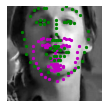

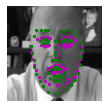

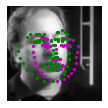

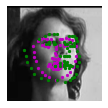

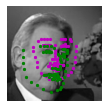

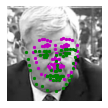

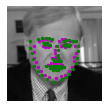

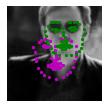

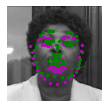

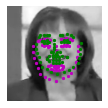

In [24]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts, cuda=True)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
# TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_nai.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

# Working with  NaimishNet

In [15]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs, cuda=True)

C:\Users\Aliab\Anaconda3\envs\cvnd\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\Users\Aliab\Anaconda3\envs\cvnd\lib\site-packages\ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch: 1, Batch: 10, Avg. Loss: 0.5488833278417588
Epoch: 1, Batch: 20, Avg. Loss: 0.4551519066095352
Epoch: 1, Batch: 30, Avg. Loss: 0.3870712697505951
Epoch: 1, Batch: 40, Avg. Loss: 0.3390173465013504
Epoch: 1, Batch: 50, Avg. Loss: 0.3197845607995987
Epoch: 1, Batch: 60, Avg. Loss: 0.2835818886756897
Epoch: 1, Batch: 70, Avg. Loss: 0.2764095261693001
Epoch: 1, Batch: 80, Avg. Loss: 0.25658878684043884
Epoch: 1, Batch: 90, Avg. Loss: 0.25587667226791383
Epoch: 1, Batch: 100, Avg. Loss: 0.24162475615739823
Epoch: 1, Batch: 110, Avg. Loss: 0.24106064736843108
Epoch: 1, Batch: 120, Avg. Loss: 0.215442556142807
Epoch: 1, Batch: 130, Avg. Loss: 0.20894510746002198
Epoch: 1, Batch: 140, Avg. Loss: 0.21880733370780944
Epoch: 1, Batch: 150, Avg. Loss: 0.1960575133562088
Epoch: 1, Batch: 160, Avg. Loss: 0.1922709345817566
Epoch: 1, Batch: 170, Avg. Loss: 0.19304388761520386



Epoch: 2, Batch: 10, Avg. Loss: 0.17235284745693208
Epoch: 2, Batch: 20, Avg. Loss: 0.17345724552869796
Epoch: 2, Batch: 30, Avg. Loss: 0.1800564184784889
Epoch: 2, Batch: 40, Avg. Loss: 0.16010401248931885
Epoch: 2, Batch: 50, Avg. Loss: 0.16267896667122841
Epoch: 2, Batch: 60, Avg. Loss: 0.14287475273013114
Epoch: 2, Batch: 70, Avg. Loss: 0.15864634439349173
Epoch: 2, Batch: 80, Avg. Loss: 0.1436130754649639
Epoch: 2, Batch: 90, Avg. Loss: 0.1378398396074772
Epoch: 2, Batch: 100, Avg. Loss: 0.14205143004655837
Epoch: 2, Batch: 110, Avg. Loss: 0.13372774198651313
Epoch: 2, Batch: 120, Avg. Loss: 0.13379905596375466
Epoch: 2, Batch: 130, Avg. Loss: 0.12330481559038162
Epoch: 2, Batch: 140, Avg. Loss: 0.11909446492791176
Epoch: 2, Batch: 150, Avg. Loss: 0.12349618449807168
Epoch: 2, Batch: 160, Avg. Loss: 0.11300390586256981
Epoch: 2, Batch: 170, Avg. Loss: 0.11298816353082657



Epoch: 3, Batch: 10, Avg. Loss: 0.11615530177950859
Epoch: 3, Batch: 20, Avg. Loss: 0.11073266118764877
Epoch: 3, Batch: 30, Avg. Loss: 0.11212960705161094
Epoch: 3, Batch: 40, Avg. Loss: 0.11217756122350693
Epoch: 3, Batch: 50, Avg. Loss: 0.09545903727412224
Epoch: 3, Batch: 60, Avg. Loss: 0.09739047065377235
Epoch: 3, Batch: 70, Avg. Loss: 0.09267586767673493
Epoch: 3, Batch: 80, Avg. Loss: 0.09316046461462975
Epoch: 3, Batch: 90, Avg. Loss: 0.0939710296690464
Epoch: 3, Batch: 100, Avg. Loss: 0.1084911771118641
Epoch: 3, Batch: 110, Avg. Loss: 0.09545897394418716
Epoch: 3, Batch: 120, Avg. Loss: 0.08996781781315803
Epoch: 3, Batch: 130, Avg. Loss: 0.09542944580316544
Epoch: 3, Batch: 140, Avg. Loss: 0.09511024877429008
Epoch: 3, Batch: 150, Avg. Loss: 0.09241829998791218
Epoch: 3, Batch: 160, Avg. Loss: 0.08097324818372727
Epoch: 3, Batch: 170, Avg. Loss: 0.0808492723852396



Epoch: 4, Batch: 10, Avg. Loss: 0.10323715731501579
Epoch: 4, Batch: 20, Avg. Loss: 0.10681835561990738
Epoch: 4, Batch: 30, Avg. Loss: 0.09288526996970177
Epoch: 4, Batch: 40, Avg. Loss: 0.09750411286950111
Epoch: 4, Batch: 50, Avg. Loss: 0.08776646926999092
Epoch: 4, Batch: 60, Avg. Loss: 0.0933427233248949
Epoch: 4, Batch: 70, Avg. Loss: 0.09100845083594322
Epoch: 4, Batch: 80, Avg. Loss: 0.09424821957945824
Epoch: 4, Batch: 90, Avg. Loss: 0.07933324128389359
Epoch: 4, Batch: 100, Avg. Loss: 0.08046747222542763
Epoch: 4, Batch: 110, Avg. Loss: 0.07567863762378693
Epoch: 4, Batch: 120, Avg. Loss: 0.08096288107335567
Epoch: 4, Batch: 130, Avg. Loss: 0.07560471221804618
Epoch: 4, Batch: 140, Avg. Loss: 0.0745279412716627
Epoch: 4, Batch: 150, Avg. Loss: 0.07163894772529603
Epoch: 4, Batch: 160, Avg. Loss: 0.06496239937841893
Epoch: 4, Batch: 170, Avg. Loss: 0.07486015073955059



Epoch: 5, Batch: 10, Avg. Loss: 0.07517973035573959
Epoch: 5, Batch: 20, Avg. Loss: 0.06043521724641323
Epoch: 5, Batch: 30, Avg. Loss: 0.06250729039311409
Epoch: 5, Batch: 40, Avg. Loss: 0.07499915026128293
Epoch: 5, Batch: 50, Avg. Loss: 0.06021000035107136
Epoch: 5, Batch: 60, Avg. Loss: 0.06255452409386635
Epoch: 5, Batch: 70, Avg. Loss: 0.049718409404158594
Epoch: 5, Batch: 80, Avg. Loss: 0.05314520671963692
Epoch: 5, Batch: 90, Avg. Loss: 0.06255914606153964
Epoch: 5, Batch: 100, Avg. Loss: 0.062075070291757586
Epoch: 5, Batch: 110, Avg. Loss: 0.06709578260779381
Epoch: 5, Batch: 120, Avg. Loss: 0.0725420031696558
Epoch: 5, Batch: 130, Avg. Loss: 0.0565820787101984
Epoch: 5, Batch: 140, Avg. Loss: 0.052480689436197284
Epoch: 5, Batch: 150, Avg. Loss: 0.04863608330488205
Epoch: 5, Batch: 160, Avg. Loss: 0.059200719743967053
Epoch: 5, Batch: 170, Avg. Loss: 0.05094284601509571



Epoch: 6, Batch: 10, Avg. Loss: 0.0601826224476099
Epoch: 6, Batch: 20, Avg. Loss: 0.0632009819149971
Epoch: 6, Batch: 30, Avg. Loss: 0.059707746095955375
Epoch: 6, Batch: 40, Avg. Loss: 0.0601724985986948
Epoch: 6, Batch: 50, Avg. Loss: 0.049756123684346676
Epoch: 6, Batch: 60, Avg. Loss: 0.05006483402103186
Epoch: 6, Batch: 70, Avg. Loss: 0.048949998989701274
Epoch: 6, Batch: 80, Avg. Loss: 0.05791892074048519
Epoch: 6, Batch: 90, Avg. Loss: 0.05075836908072233
Epoch: 6, Batch: 100, Avg. Loss: 0.050451310351490974
Epoch: 6, Batch: 110, Avg. Loss: 0.05423501692712307
Epoch: 6, Batch: 120, Avg. Loss: 0.05404509827494621
Epoch: 6, Batch: 130, Avg. Loss: 0.04732907209545374
Epoch: 6, Batch: 140, Avg. Loss: 0.06447664350271225
Epoch: 6, Batch: 150, Avg. Loss: 0.054448111727833745
Epoch: 6, Batch: 160, Avg. Loss: 0.04545202478766441
Epoch: 6, Batch: 170, Avg. Loss: 0.050352683663368224



Epoch: 7, Batch: 10, Avg. Loss: 0.052956321462988856
Epoch: 7, Batch: 20, Avg. Loss: 0.05386265143752098
Epoch: 7, Batch: 30, Avg. Loss: 0.053267003409564494
Epoch: 7, Batch: 40, Avg. Loss: 0.0510161854326725
Epoch: 7, Batch: 50, Avg. Loss: 0.05416047144681215
Epoch: 7, Batch: 60, Avg. Loss: 0.04981668964028359
Epoch: 7, Batch: 70, Avg. Loss: 0.040889883786439894
Epoch: 7, Batch: 80, Avg. Loss: 0.04043026324361563
Epoch: 7, Batch: 90, Avg. Loss: 0.048770496249198915
Epoch: 7, Batch: 100, Avg. Loss: 0.050747120566666123
Epoch: 7, Batch: 110, Avg. Loss: 0.050999832898378374
Epoch: 7, Batch: 120, Avg. Loss: 0.05071762762963772
Epoch: 7, Batch: 130, Avg. Loss: 0.05940899457782507
Epoch: 7, Batch: 140, Avg. Loss: 0.05370043143630028
Epoch: 7, Batch: 150, Avg. Loss: 0.03939241655170918
Epoch: 7, Batch: 160, Avg. Loss: 0.06053437702357769
Epoch: 7, Batch: 170, Avg. Loss: 0.0451922869309783



Epoch: 8, Batch: 10, Avg. Loss: 0.05513073429465294
Epoch: 8, Batch: 20, Avg. Loss: 0.05024098064750433
Epoch: 8, Batch: 30, Avg. Loss: 0.04655834157019854
Epoch: 8, Batch: 40, Avg. Loss: 0.04173700790852308
Epoch: 8, Batch: 50, Avg. Loss: 0.04892240166664123
Epoch: 8, Batch: 60, Avg. Loss: 0.0642136164009571
Epoch: 8, Batch: 70, Avg. Loss: 0.04243363067507744
Epoch: 8, Batch: 80, Avg. Loss: 0.06053350530564785
Epoch: 8, Batch: 90, Avg. Loss: 0.046796159259974955
Epoch: 8, Batch: 100, Avg. Loss: 0.051714594848454
Epoch: 8, Batch: 110, Avg. Loss: 0.05333136506378651
Epoch: 8, Batch: 120, Avg. Loss: 0.039653468318283557
Epoch: 8, Batch: 130, Avg. Loss: 0.049907402135431767
Epoch: 8, Batch: 140, Avg. Loss: 0.058205419592559336
Epoch: 8, Batch: 150, Avg. Loss: 0.04546957593411207
Epoch: 8, Batch: 160, Avg. Loss: 0.05092092677950859
Epoch: 8, Batch: 170, Avg. Loss: 0.04723980817943811



Epoch: 9, Batch: 10, Avg. Loss: 0.05898786224424839
Epoch: 9, Batch: 20, Avg. Loss: 0.05801765210926533
Epoch: 9, Batch: 30, Avg. Loss: 0.06397468466311693
Epoch: 9, Batch: 40, Avg. Loss: 0.05548376105725765
Epoch: 9, Batch: 50, Avg. Loss: 0.05937180109322071
Epoch: 9, Batch: 60, Avg. Loss: 0.04759810790419579
Epoch: 9, Batch: 70, Avg. Loss: 0.05290785264223814
Epoch: 9, Batch: 80, Avg. Loss: 0.05157427489757538
Epoch: 9, Batch: 90, Avg. Loss: 0.044060103967785834
Epoch: 9, Batch: 100, Avg. Loss: 0.05748412944376469
Epoch: 9, Batch: 110, Avg. Loss: 0.041431307792663574
Epoch: 9, Batch: 120, Avg. Loss: 0.054438262805342676
Epoch: 9, Batch: 130, Avg. Loss: 0.04923975393176079
Epoch: 9, Batch: 140, Avg. Loss: 0.0523613765835762
Epoch: 9, Batch: 150, Avg. Loss: 0.04304023738950491
Epoch: 9, Batch: 160, Avg. Loss: 0.04514322951436043
Epoch: 9, Batch: 170, Avg. Loss: 0.051475339382886884



Epoch: 10, Batch: 10, Avg. Loss: 0.059699739515781405
Epoch: 10, Batch: 20, Avg. Loss: 0.0710047572851181
Epoch: 10, Batch: 30, Avg. Loss: 0.061640160903334615
Epoch: 10, Batch: 40, Avg. Loss: 0.053629938326776025
Epoch: 10, Batch: 50, Avg. Loss: 0.0506689365953207
Epoch: 10, Batch: 60, Avg. Loss: 0.048851219564676286
Epoch: 10, Batch: 70, Avg. Loss: 0.056426241807639596
Epoch: 10, Batch: 80, Avg. Loss: 0.058945123106241226
Epoch: 10, Batch: 90, Avg. Loss: 0.05459828749299049
Epoch: 10, Batch: 100, Avg. Loss: 0.04167315177619457
Epoch: 10, Batch: 110, Avg. Loss: 0.05151800140738487
Epoch: 10, Batch: 120, Avg. Loss: 0.05955613777041435
Epoch: 10, Batch: 130, Avg. Loss: 0.04197915308177471
Epoch: 10, Batch: 140, Avg. Loss: 0.04255516566336155
Epoch: 10, Batch: 150, Avg. Loss: 0.04815278202295303
Epoch: 10, Batch: 160, Avg. Loss: 0.04481284134089947
Epoch: 10, Batch: 170, Avg. Loss: 0.05628295615315437



Epoch: 11, Batch: 10, Avg. Loss: 0.050059974752366544
Epoch: 11, Batch: 20, Avg. Loss: 0.0516216840595007
Epoch: 11, Batch: 30, Avg. Loss: 0.05509793870151043
Epoch: 11, Batch: 40, Avg. Loss: 0.045837944746017455
Epoch: 11, Batch: 50, Avg. Loss: 0.04806647635996342
Epoch: 11, Batch: 60, Avg. Loss: 0.05148312896490097
Epoch: 11, Batch: 70, Avg. Loss: 0.0365420188754797
Epoch: 11, Batch: 80, Avg. Loss: 0.04591153208166361
Epoch: 11, Batch: 90, Avg. Loss: 0.04440209567546845
Epoch: 11, Batch: 100, Avg. Loss: 0.03796728942543268
Epoch: 11, Batch: 110, Avg. Loss: 0.0343405157327652
Epoch: 11, Batch: 120, Avg. Loss: 0.046500488743186
Epoch: 11, Batch: 130, Avg. Loss: 0.03507036007940769
Epoch: 11, Batch: 140, Avg. Loss: 0.03922115173190832
Epoch: 11, Batch: 150, Avg. Loss: 0.051096124947071074
Epoch: 11, Batch: 160, Avg. Loss: 0.04673377238214016
Epoch: 11, Batch: 170, Avg. Loss: 0.03687509559094906



Epoch: 12, Batch: 10, Avg. Loss: 0.058979793824255465
Epoch: 12, Batch: 20, Avg. Loss: 0.041993402689695356
Epoch: 12, Batch: 30, Avg. Loss: 0.041260180063545704
Epoch: 12, Batch: 40, Avg. Loss: 0.04572688303887844
Epoch: 12, Batch: 50, Avg. Loss: 0.05104872174561024
Epoch: 12, Batch: 60, Avg. Loss: 0.04061951860785484
Epoch: 12, Batch: 70, Avg. Loss: 0.0532991910353303
Epoch: 12, Batch: 80, Avg. Loss: 0.04737421423196793
Epoch: 12, Batch: 90, Avg. Loss: 0.031512006931006906
Epoch: 12, Batch: 100, Avg. Loss: 0.046390806883573533
Epoch: 12, Batch: 110, Avg. Loss: 0.04558056443929672
Epoch: 12, Batch: 120, Avg. Loss: 0.04581466838717461
Epoch: 12, Batch: 130, Avg. Loss: 0.04907697234302759
Epoch: 12, Batch: 140, Avg. Loss: 0.04990164749324322
Epoch: 12, Batch: 150, Avg. Loss: 0.04537556953728199
Epoch: 12, Batch: 160, Avg. Loss: 0.03797515705227852
Epoch: 12, Batch: 170, Avg. Loss: 0.05151892509311438



Epoch: 13, Batch: 10, Avg. Loss: 0.03836340922862291
Epoch: 13, Batch: 20, Avg. Loss: 0.04049595575779676
Epoch: 13, Batch: 30, Avg. Loss: 0.041847653314471246
Epoch: 13, Batch: 40, Avg. Loss: 0.04238644950091839
Epoch: 13, Batch: 50, Avg. Loss: 0.05612827390432358
Epoch: 13, Batch: 60, Avg. Loss: 0.055062173120677474
Epoch: 13, Batch: 70, Avg. Loss: 0.038543636165559295
Epoch: 13, Batch: 80, Avg. Loss: 0.045002243109047414
Epoch: 13, Batch: 90, Avg. Loss: 0.048320936784148213
Epoch: 13, Batch: 100, Avg. Loss: 0.045842929556965825
Epoch: 13, Batch: 110, Avg. Loss: 0.04030713438987732
Epoch: 13, Batch: 120, Avg. Loss: 0.04218413159251213
Epoch: 13, Batch: 130, Avg. Loss: 0.03494038935750723
Epoch: 13, Batch: 140, Avg. Loss: 0.04501693807542324
Epoch: 13, Batch: 150, Avg. Loss: 0.03208199553191662
Epoch: 13, Batch: 160, Avg. Loss: 0.03507201168686151
Epoch: 13, Batch: 170, Avg. Loss: 0.041353719495236876



Epoch: 14, Batch: 10, Avg. Loss: 0.04587772376835346
Epoch: 14, Batch: 20, Avg. Loss: 0.03793177343904972
Epoch: 14, Batch: 30, Avg. Loss: 0.04216244351118803
Epoch: 14, Batch: 40, Avg. Loss: 0.03712780904024839
Epoch: 14, Batch: 50, Avg. Loss: 0.0363392123952508
Epoch: 14, Batch: 60, Avg. Loss: 0.04311277456581593
Epoch: 14, Batch: 70, Avg. Loss: 0.038248402439057826
Epoch: 14, Batch: 80, Avg. Loss: 0.041302626952528954
Epoch: 14, Batch: 90, Avg. Loss: 0.04484811257570982
Epoch: 14, Batch: 100, Avg. Loss: 0.0352013798430562
Epoch: 14, Batch: 110, Avg. Loss: 0.03839287925511599
Epoch: 14, Batch: 120, Avg. Loss: 0.0476572722196579
Epoch: 14, Batch: 130, Avg. Loss: 0.03489071205258369
Epoch: 14, Batch: 140, Avg. Loss: 0.036185328289866446
Epoch: 14, Batch: 150, Avg. Loss: 0.039371610060334204
Epoch: 14, Batch: 160, Avg. Loss: 0.03488043360412121
Epoch: 14, Batch: 170, Avg. Loss: 0.041293468326330185



Epoch: 15, Batch: 10, Avg. Loss: 0.045792180299758914
Epoch: 15, Batch: 20, Avg. Loss: 0.05108785312622786
Epoch: 15, Batch: 30, Avg. Loss: 0.03345643039792776
Epoch: 15, Batch: 40, Avg. Loss: 0.03388403840363026
Epoch: 15, Batch: 50, Avg. Loss: 0.04185610208660364
Epoch: 15, Batch: 60, Avg. Loss: 0.040056582726538184
Epoch: 15, Batch: 70, Avg. Loss: 0.04725234247744083
Epoch: 15, Batch: 80, Avg. Loss: 0.031570008397102355
Epoch: 15, Batch: 90, Avg. Loss: 0.0359301382675767
Epoch: 15, Batch: 100, Avg. Loss: 0.03549667205661535
Epoch: 15, Batch: 110, Avg. Loss: 0.03602435439825058
Epoch: 15, Batch: 120, Avg. Loss: 0.03542626425623894
Epoch: 15, Batch: 130, Avg. Loss: 0.03639551922678948
Epoch: 15, Batch: 140, Avg. Loss: 0.046240464225411414
Epoch: 15, Batch: 150, Avg. Loss: 0.03806904889643192
Epoch: 15, Batch: 160, Avg. Loss: 0.04099628385156393
Epoch: 15, Batch: 170, Avg. Loss: 0.03867566343396902



Epoch: 16, Batch: 10, Avg. Loss: 0.046182723343372346
Epoch: 16, Batch: 20, Avg. Loss: 0.04289830271154642
Epoch: 16, Batch: 30, Avg. Loss: 0.05269629918038845
Epoch: 16, Batch: 40, Avg. Loss: 0.039534789882600306
Epoch: 16, Batch: 50, Avg. Loss: 0.042297867871820924
Epoch: 16, Batch: 60, Avg. Loss: 0.047863458283245564
Epoch: 16, Batch: 70, Avg. Loss: 0.062186121568083765
Epoch: 16, Batch: 80, Avg. Loss: 0.04774665553122759
Epoch: 16, Batch: 90, Avg. Loss: 0.04075935278087854
Epoch: 16, Batch: 100, Avg. Loss: 0.03771194275468588
Epoch: 16, Batch: 110, Avg. Loss: 0.03791622333228588
Epoch: 16, Batch: 120, Avg. Loss: 0.03966991752386093
Epoch: 16, Batch: 130, Avg. Loss: 0.039262797497212884
Epoch: 16, Batch: 140, Avg. Loss: 0.0311481025069952
Epoch: 16, Batch: 150, Avg. Loss: 0.04578351192176342
Epoch: 16, Batch: 160, Avg. Loss: 0.031401806883513926
Epoch: 16, Batch: 170, Avg. Loss: 0.038909310661256316



Epoch: 17, Batch: 10, Avg. Loss: 0.038093227334320544
Epoch: 17, Batch: 20, Avg. Loss: 0.04105520360171795
Epoch: 17, Batch: 30, Avg. Loss: 0.036429925449192525
Epoch: 17, Batch: 40, Avg. Loss: 0.04280095361173153
Epoch: 17, Batch: 50, Avg. Loss: 0.04627051763236523
Epoch: 17, Batch: 60, Avg. Loss: 0.033646400459110735
Epoch: 17, Batch: 70, Avg. Loss: 0.03326280061155558
Epoch: 17, Batch: 80, Avg. Loss: 0.035283816047012806
Epoch: 17, Batch: 90, Avg. Loss: 0.04423153009265661
Epoch: 17, Batch: 100, Avg. Loss: 0.05195045117288828
Epoch: 17, Batch: 110, Avg. Loss: 0.03207971602678299
Epoch: 17, Batch: 120, Avg. Loss: 0.03252178393304348
Epoch: 17, Batch: 130, Avg. Loss: 0.03354820888489485
Epoch: 17, Batch: 140, Avg. Loss: 0.03566709477454424
Epoch: 17, Batch: 150, Avg. Loss: 0.03762237131595612
Epoch: 17, Batch: 160, Avg. Loss: 0.034541933611035344
Epoch: 17, Batch: 170, Avg. Loss: 0.03479168247431517



Epoch: 18, Batch: 10, Avg. Loss: 0.03330937493592501
Epoch: 18, Batch: 20, Avg. Loss: 0.03802532814443112
Epoch: 18, Batch: 30, Avg. Loss: 0.04644772820174694
Epoch: 18, Batch: 40, Avg. Loss: 0.04366147015243769
Epoch: 18, Batch: 50, Avg. Loss: 0.033768263086676596
Epoch: 18, Batch: 60, Avg. Loss: 0.03580024782568216
Epoch: 18, Batch: 70, Avg. Loss: 0.040165060013532636
Epoch: 18, Batch: 80, Avg. Loss: 0.0432068495079875
Epoch: 18, Batch: 90, Avg. Loss: 0.04446968454867602
Epoch: 18, Batch: 100, Avg. Loss: 0.038709848374128344
Epoch: 18, Batch: 110, Avg. Loss: 0.04099346678704023
Epoch: 18, Batch: 120, Avg. Loss: 0.031028974428772928
Epoch: 18, Batch: 130, Avg. Loss: 0.03796961475163698
Epoch: 18, Batch: 140, Avg. Loss: 0.03107305206358433
Epoch: 18, Batch: 150, Avg. Loss: 0.036456991545856
Epoch: 18, Batch: 160, Avg. Loss: 0.036318559944629666
Epoch: 18, Batch: 170, Avg. Loss: 0.039906506054103376



Epoch: 19, Batch: 10, Avg. Loss: 0.04675506129860878
Epoch: 19, Batch: 20, Avg. Loss: 0.037644094042479995
Epoch: 19, Batch: 30, Avg. Loss: 0.034226500615477565
Epoch: 19, Batch: 40, Avg. Loss: 0.036675823479890825
Epoch: 19, Batch: 50, Avg. Loss: 0.03762733861804009
Epoch: 19, Batch: 60, Avg. Loss: 0.037105281464755537
Epoch: 19, Batch: 70, Avg. Loss: 0.036800905503332614
Epoch: 19, Batch: 80, Avg. Loss: 0.03190015554428101
Epoch: 19, Batch: 90, Avg. Loss: 0.0401382889598608
Epoch: 19, Batch: 100, Avg. Loss: 0.03177148643881082
Epoch: 19, Batch: 110, Avg. Loss: 0.03300636019557714
Epoch: 19, Batch: 120, Avg. Loss: 0.05405948050320149
Epoch: 19, Batch: 130, Avg. Loss: 0.0415306456387043
Epoch: 19, Batch: 140, Avg. Loss: 0.029203702695667744
Epoch: 19, Batch: 150, Avg. Loss: 0.031120482832193375
Epoch: 19, Batch: 160, Avg. Loss: 0.03128119008615613
Epoch: 19, Batch: 170, Avg. Loss: 0.03724241480231285



Epoch: 20, Batch: 10, Avg. Loss: 0.030744487419724464
Epoch: 20, Batch: 20, Avg. Loss: 0.04591470453888178
Epoch: 20, Batch: 30, Avg. Loss: 0.03836870640516281
Epoch: 20, Batch: 40, Avg. Loss: 0.04783166497945786
Epoch: 20, Batch: 50, Avg. Loss: 0.04070532470941544
Epoch: 20, Batch: 60, Avg. Loss: 0.03260679226368666
Epoch: 20, Batch: 70, Avg. Loss: 0.03984575737267733
Epoch: 20, Batch: 80, Avg. Loss: 0.03470972590148449
Epoch: 20, Batch: 90, Avg. Loss: 0.04346027635037899
Epoch: 20, Batch: 100, Avg. Loss: 0.030523332580924035
Epoch: 20, Batch: 110, Avg. Loss: 0.04030118733644485
Epoch: 20, Batch: 120, Avg. Loss: 0.03430844824761152
Epoch: 20, Batch: 130, Avg. Loss: 0.04571518842130899
Epoch: 20, Batch: 140, Avg. Loss: 0.04446458648890257
Epoch: 20, Batch: 150, Avg. Loss: 0.03765586521476507
Epoch: 20, Batch: 160, Avg. Loss: 0.029241234250366687
Epoch: 20, Batch: 170, Avg. Loss: 0.03553982600569725


Finished Training


In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(cuda=True)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


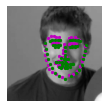

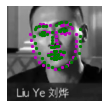

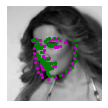

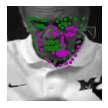

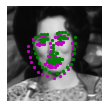

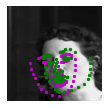

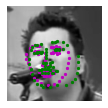

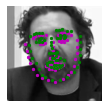

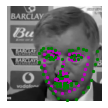

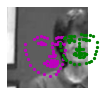

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts, cuda=True)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I choose Adam optimizer, because Adam is an adaptive learning rate optimimization algorithm. Adam can reach a global maximum fasther than SGD and the trend shows Adam is being used more often in research than any other optimzer. Thats why I choose adam optimizer. 
Initially I choose MSELoss because this is a regression problem and MSELoss seems to be a resonable option for this kind of problem. With several experiments on Both MSELoss and SmoothLoss. I discovered that SmoothL1Loss work best.  

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Initially, I started with a custom model having 5 convoluional layers and 2 fully connected layers. But the model seems to overfit after 4 epochs, so I added two dropout layers with p=0.5 but still the results were not as good as expected. 

Then I modified my model and used 2 CNN layers along with Batchnormalization layers and two FC layers with dropout of p=0.4 for each and a final fc layer for output. With several experiments I finally get a good model that suits best. I included layers initialization and applied Xavier uniform initialization. 

Later on, I used the NaimishNet model for this task, which also gave some good results also. This model gave me more accurate results and overall detection was improved.


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I tested my model both on GPU and CPU. For the GPU I run the notebook on my personal computer having Nvidia GTx 1070 and compared it with the model run on CPU within the course. I noticed there was a drastic change in epochs execution on GPU and CPU. It took me 10 mins to finish 20 epochs on the GPU while the CPU took almost an hour to finish the job.

Initially, I trained my model for 6 epochs and the reviewer suggested that I train it more to get good results. After I trained the model for 20 epochs, it showed good results on the data and I rechead to a loss of 0.0907. I didn't train it further because the model seems to show no decrease in loss after 16 - 17 epochs. 

At first I chose a batch size of 64 and kept on reducing until my GPU memory was resolved. At 20 batch size my GPU worked on a jupyter notebook which was very weird but I found this is a problem with jupyter notebook, that's why I stayed with 20 batch size. 


## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.06222917 -0.03165538 -0.0445208  -0.09054075 -0.20759454]
 [-0.18853278 -0.11507392  0.1261573  -0.06751598 -0.09408283]
 [-0.16036071 -0.05590602 -0.05773694 -0.10624959  0.16904512]
 [-0.15249202 -0.09440318 -0.0330537  -0.17482363  0.07619244]
 [ 0.01527161 -0.09240755  0.13135728 -0.10827264 -0.05862122]]
(5, 5)


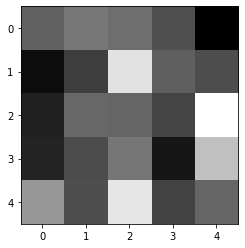

In [27]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
# weights1 = net.module.conv1.weight.data
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

Filters from First CNN layers


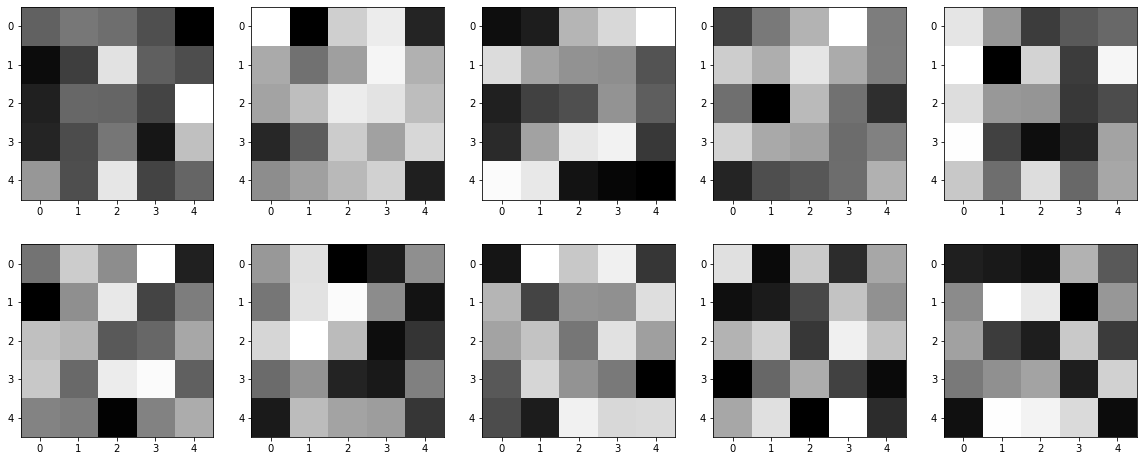

In [28]:
##TODO: load in and display any image from the transformed test dataset
# weights = net.module.conv1.weight.data
# w = weights.cpu().numpy()

weights = net.conv1.weight.data
w = weights.cpu().numpy()

# for 10 filters
fig = plt.figure(figsize=(20, 8))
column = 5
rows = 2
for i in range(0, column * rows):
    fig.add_subplot(rows, column, i+1)
    plt.imshow(w[i][0], cmap='gray')

print('Filters from First CNN layers')
plt.show()


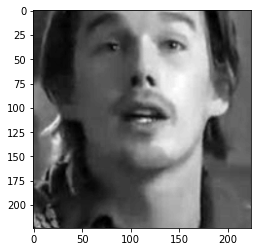

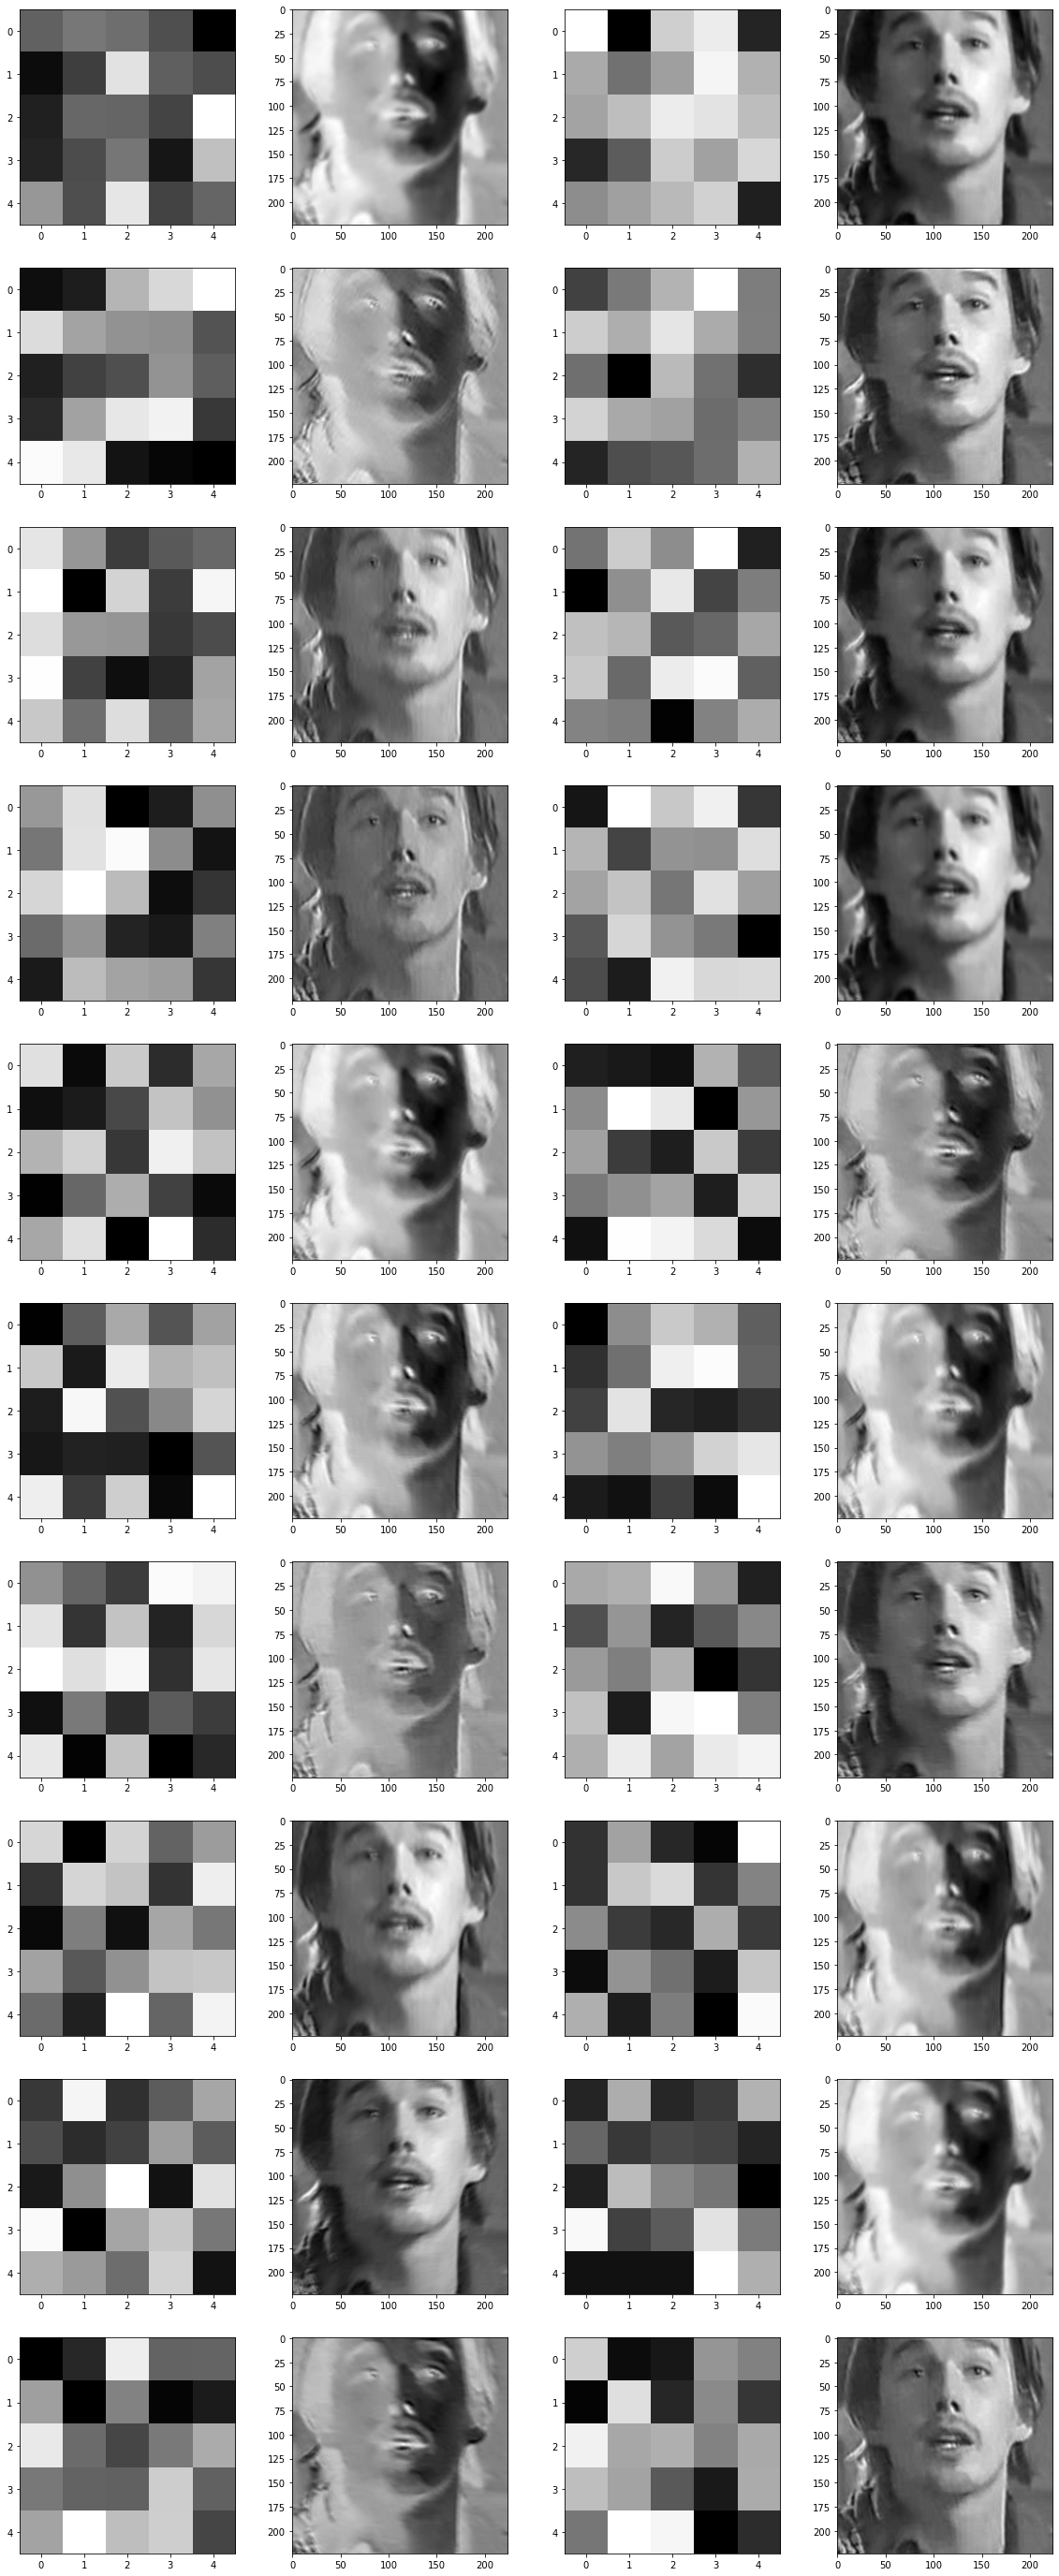

In [29]:
import cv2
img = np.squeeze(test_images[0]).cpu()
img = np.array(img)

plt.imshow(img, cmap='gray')
# weights = net.module.conv1.weight.data
# w = weights.cpu().numpy()
weights = net.conv1.weight.data
w = weights.cpu().numpy()

fig = plt.figure(figsize=(20, 50))
columns = 4
rows = 10

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if((i%2) == 0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: From the above graphs and plots, I noticed that most of the filters applied were edge detectors and illumination detectors.

The First filter shows a change in illumination condition, a noticeable change of illumination on eyes, eyebrows, mouth nose and hair was noticed. This seems to be an illumination detecting filter. 

The second last filter act like an edge detector filter, boothing features or in other words detecting the changes occuring near mouth, eyes and nose for keypoints detection. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!